## Imports

In [1]:
import sys
from multiprocessing import Pool

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist
from copy import deepcopy
import warnings
from numba import njit, prange
from arviz.labels import MapLabeller
from eryn.ensemble import EnsembleSampler
from eryn.moves import (
    CombineMove,
    DistributionGenerateRJ,
    GaussianMove,
    MTDistGenMoveRJ,
    StretchMove,
    GroupStretchMove,
)
from eryn.prior import ProbDistContainer
from eryn.state import State
from eryn.utils import TransformContainer
from eryn.utils.utility import groups_from_inds
from scipy.stats import invgamma, norm, uniform
from sklearn.model_selection import KFold, train_test_split

sys.path.append("../../TFM/rk-bfr")
seed = 42
rng = np.random.default_rng(seed)
np.random.seed(seed)

import utils.simulation_utils as simulation
from utils import plot_utils

%matplotlib inline
%load_ext autoreload
%load_ext watermark
%autoreload 2

## Dataset

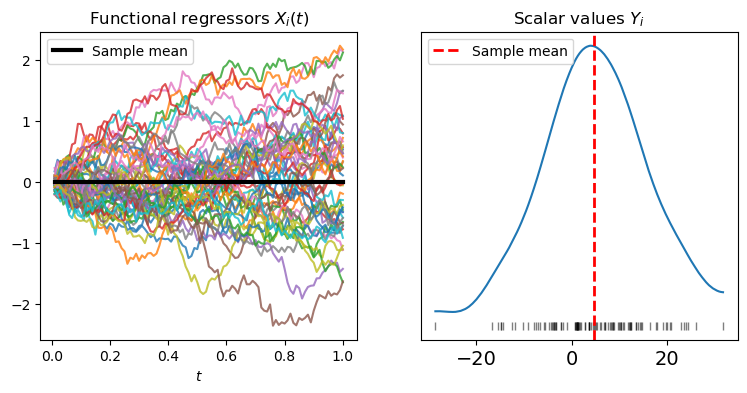

In [2]:
# define true parameters
component_params = np.array(
    [
        [-5, 0.1],
        [5, 0.6],
        [10, 0.8],
    ]
)
alpha0 = 5
sigma2 = 0.5

# define dataset parameters
ngrid = 100
n_train, n_test = 100, 50
mean_vector = np.zeros(ngrid)
kernel_fn = simulation.brownian_kernel

# generate regressors and response
t = np.linspace(1.0 / ngrid, 1, ngrid)
x = simulation.gp(t, mean_vector, kernel_fn, n_train + n_test, rng=rng)
y = simulation.generate_rkhs_dataset(
    x, t, component_params.T[0], component_params.T[1], alpha0, sigma2, rng=rng
)
y_noiseless = simulation.generate_rkhs_dataset(
    x, t, component_params.T[0], component_params.T[1], alpha0, 0.0, rng=rng
)

# Train/test split and standardize
indices = np.arange(n_train + n_test)  # for future convenience
X, X_test, Y, Y_test, idx_train, idx_test = train_test_split(
    x, y, indices, train_size=n_train, random_state=seed
)
X, X_test = simulation.standardize_predictors(X, X_test, scale=False)
# Y, Y_test = simulation.standardize_response(Y, Y_test)

# Plot dataset
plot_utils.plot_dataset_regression(
    X,
    Y,
    n_samples=n_train // 2,
)

## Bayesian model

### Prior

In [3]:
class jeffreys_prior:
    """Jeffrey's prior P(sigma2) ∝ 1/sigma2. It is equivalent to flat prior on log(sigma)"""

    def logpdf(self, x):
        """It receives an array (N,) of samples. It must check the bounds and return an array
        (N,) with -np.inf in positions of invalid values."""
        res = np.full_like(x, -np.inf)
        idx_valid = np.where(x > 0)  # identify samples where sigma2 > 0
        res[idx_valid] = -np.log(x[idx_valid])  # log P(sigma2) ∝ -log(sigma2)
        return res


def uniform_dist(a, b):
    """Wrapper around scipy.stats.uniform; similar to eryn.prior.uniform_dist, but without
    the error that it needs floating numbers as input to logpdf or else it fails."""
    return uniform(loc=a, scale=b - a)


class RKHSPriorSimple:
    """the prior on p (the number of components) is assumed to be uniform in [1, n_leaves_max]"""

    def __init__(self, t, X, Y_mean):
        # Dataset information
        self.t = t
        self.X = x
        self.Y_mean = Y_mean

        # Indices in the coords array
        self.idx_beta = 0
        self.idx_tau = 1
        self.idx_alpha0 = 0
        self.idx_sigma2 = 1

        # Independent priors
        self.prior_beta = norm(0, 10)
        self.prior_tau = uniform_dist(t.min(), t.max())
        self.prior_sigma2 = jeffreys_prior()

    def logpdf_components(self, coords, inds_components):
        """inds_components is a multi-index (3-uple of arrays) for coords["components"],
        which indicates the components for which to compute the logpdf."""
        # Get current values of theta
        beta = coords["components"][..., self.idx_beta]
        tau = coords["components"][..., self.idx_tau]

        # Compute logpdf for beta and tau
        lp_beta = self.prior_beta.logpdf(beta[inds_components])
        lp_tau = self.prior_tau.logpdf(tau[inds_components])

        return lp_beta + lp_tau

    def logpdf(self, coords, inds):
        # Get current values of theta
        beta = coords["components"][..., self.idx_beta]
        tau = coords["components"][..., self.idx_tau]
        alpha0 = coords["common"][..., self.idx_alpha0]
        sigma2 = coords["common"][..., self.idx_sigma2]

        # Get conditional priors
        prior_alpha0 = self._get_prior_alpha0(sigma2)

        # Compute logpdf for beta and tau
        lp_beta = self.prior_beta.logpdf(beta)  # (ntemps, nwalkers, nleaves_max)
        lp_tau = self.prior_tau.logpdf(tau)  # (ntemps, nwalkers, nleaves_max)

        # Compute logpdf for alpha0 and sigma2
        lp_alpha0 = prior_alpha0.logpdf(alpha0)[..., 0]  # (ntemps, nwalkers)
        lp_sigma2 = self.prior_sigma2.logpdf(sigma2)[..., 0]  # (ntemps, nwalkers)

        # Turn off contribution of inactive leaves
        lp_beta[~inds["components"]] = 0.0
        lp_tau[~inds["components"]] = 0.0
        lp_alpha0[np.isinf(lp_sigma2)] = 0.0  # Fix NaN in lp_alpha0

        return lp_beta.sum(axis=-1) + lp_tau.sum(axis=-1) + lp_alpha0 + lp_sigma2

    def rvs(self, size, coords=None, inds=None):
        """arguments coords are size are present for compatibility"""
        # Only generate samples for the RJ moves
        out = np.zeros((size,) + (2,))

        out[..., self.idx_beta] = self.prior_beta.rvs(size=size)
        out[..., self.idx_tau] = self.prior_tau.rvs(size=size)

        return out

    def _get_prior_alpha0(self, sigma2):
        # Ignore warning when doing sqrt of a negative number; those positions are ignored later
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            return norm(0, 10 * np.abs(self.Y_mean) * np.sqrt(sigma2))


priors_simple = {"all_models_together": RKHSPriorSimple(t, X, Y.mean())}

priors_initial = {
    "components": ProbDistContainer(
        {
            0: priors_simple[
                "all_models_together"
            ].prior_beta,  # beta  TODO: elegir según la escala de los datos (?)
            1: uniform_dist(t.min(), t.max()),  # tau
        }
    ),
    "common": ProbDistContainer(
        {
            0: norm(
                0, 10 * np.abs(Y.mean())
            ),  # alpha0  TODO: elegir según la escala de los datos (?)
            1: jeffreys_prior(),  # P(sigma2) ∝ 1/sigma2
        }
    ),
}

### Likelihood

In [4]:
class RKHSLikelihood:
    def __init__(self, t, X, y):
        self.t = t
        self.X_T = np.ascontiguousarray(X.T)
        self.y = y
        self.n = X.shape[0]

    # METHOD 1: Sequential computation for future parallelization with pool argument in Eryn
    def evaluate_sequential(self, theta):
        """Computes the log-likelihood log P(Y1,...,Y_n|theta, X_1, ..., X_n) for a single walker.

        - theta is a list [theta_components, theta_common] that represent the parameters for a single walker.
            * theta_components is an array (p, 2) of the parameters (b_j, t_j) for each component (leaf), where 1<=p<=p_max.
              In other words, on each call to this function the shape varies according to how many leaves are active.
            * theta_common is an array (1, 2) of the parameters alpha_0 and sigma^2, which are common for all models (leaves).
        - t is the discretized grid of shape (ngrid,)
        - X, y are the data, of shape (nfunc, ngrid) and (nfunc,) respectively.

        ========
        Return: the log-likelihood for the walker, i.e., log P(Y|theta, X).

        ========
        Note: Eryn already checks that the theta input values are valid (i.e. within the bounds of the prior).
        """
        theta_components, theta_common = theta
        beta = np.ascontiguousarray(theta_components[:, 0])
        tau = np.ascontiguousarray(theta_components[:, 1:2])
        alpha0 = theta_common[0][0]
        sigma2 = theta_common[0][1]

        # Compute the indices of the grid corresponding to the parameter tau
        idx_tau = cdist(tau, self.t[:, None], 'cityblock').argmin(axis=1)  # == np.abs(self.t - tau).argmin(axis=1)

        diff = self.y - alpha0 - self.X_T[idx_tau].T @ beta
        ll = -self.n * np.log(np.sqrt(sigma2)) - 0.5 * (diff @ diff) / sigma2

        return ll

    # Method 2: Vectorized computation with parallel execution of inner loop
    def evaluate_vectorized(self, theta, groups):
        """Computes the log-likelihood log P(Y_1,...,Y_n|[Theta], X_1, ..., X_n) for all walkers and temps.

        - theta is a list [theta_components, theta_common] that represents the parameters for _all_ walkers (across
          all temperatures).
            * theta_components is an array (N, 2) of the parameters (b_j, t_j) for all walkers and temps. N is the total
              number of active parameters in the RJ branch, i.e., N=sum(inds["components"]). Informally, we can
              compute N as nwalkers*ntemps*(active leaves on each (nwalker, ntemp)). In these arrays we have no
              information about which walker the parameters belong to; we just know their values.
            * theta_common is an array (M, 2) of the parameters alpha_0 and sigma^2 for all walkers and temps. M is
              the total number of such parameters (which is fixed), i.e., M=nwalkers*ntemps. In general, N >= M.
        - groups is a list [groups_components, groups_common] that represents the correspondence between parameters
          in the flattened array theta_* and the specific walker they belong to. Each group_* array contains integers,
          and each position within them represents the walker #id of the corresponding parameter in the same position
          on the theta_* array of parameters. The range of possible values is {1, 2, ..., M}. Eryn internally converts
          the inds array to groups information (eryn.utils.groups_from_inds), so that only active parameters are
          considered for the likelihood computation.
            * groups_components is an array (N,).
            * groups_common is an array (M,), and since the corresponding parameters are fixed and nleaves_min=1 in this
              branch, groups_common=np.arange(M). This parameter can be safely ignored.
        - t is the grid of shape (ngrid,)
        - X, y are the data, of shape (nfunc, ngrid) and (nfunc,) respectively.

        ========
        Example: suppose ntemps=2, nwalkers=2, and on each of the 4 total walkers we have 1, 2, 3 and 2 components active,
                 respectively. Then, N=1+2+3+2=8, while M=2*2=4. We would have groups_components = [0,1,1,2,2,2,3,3]
                 and groups_common = [0,1,2,3]. To compute the likelihood for walker i, we have to collect all theta_components
                 corresponding to this walker #id (whose indices are given by np.where(groups_components == i)), as well as
                 the corresponding alpha_0 and sigma^2 (theta_common[i]), and perform the computation per the model.

        ========
        Return: array (M,) in which each position is the log-likelihood for a specific walker, i.e.,
                log P(Y|Theta_i, X) (i=1,...,M).

        ========
        Note: Eryn already checks that the theta input values are valid (i.e. within the bounds of the prior).
        """
        theta_components, theta_common = theta
        groups_components, _ = groups

        beta = np.ascontiguousarray(theta_components[:, 0])
        tau = np.ascontiguousarray(theta_components[:, 1:2])
        alpha0 = np.ascontiguousarray(theta_common[:, 0])
        sigma2 = np.ascontiguousarray(theta_common[:, 1])

        idx_tau = cdist(tau, self.t[:, None], 'cityblock').argmin(axis=1)  # == np.abs(self.t - tau).argmin(axis=1)
        unique_indices = np.unique(groups_components)

        ll = self._compute_ll_parallel(
            groups_components,
            unique_indices,
            beta,
            idx_tau,
            alpha0,
            sigma2,
            self.X_T,
            self.y,
            self.n,
        )

        return ll

    # Actual parallel computation of log_likelihood for all groups
    @staticmethod
    @njit(
        parallel=True,
        fastmath=True,
        cache=True,
    )
    def _compute_ll_parallel(
        groups_components: np.ndarray,
        unique_indices: np.ndarray,
        beta: np.ndarray,
        idx_tau: np.ndarray,
        alpha0: np.ndarray,
        sigma2: np.ndarray,
        X_T: np.ndarray,
        y: np.ndarray,
        n: np.ndarray,
    ) -> np.ndarray:
        # Preallocate memory
        ll = np.empty_like(unique_indices, dtype=np.float64)
        X_tau_masked = np.empty_like(X_T[0])
        beta_masked = np.empty_like(beta[0])
        diff = np.empty_like(y)

        for i in prange(len(unique_indices)):
            idx = unique_indices[i]
            mask = np.where(groups_components == idx)
            X_tau_masked = np.ascontiguousarray(X_T[idx_tau[mask]])
            beta_masked = beta[mask]
            alpha0_masked = alpha0[idx]
            sigma2_masked = sigma2[idx]
            log_sigma_masked = np.log(np.sqrt(sigma2_masked))

            diff = y - alpha0_masked - np.dot(X_tau_masked.T, beta_masked)
            ll[i] = -n * log_sigma_masked - 0.5 * np.dot(diff, diff) / sigma2_masked

        return ll

## Sampler

### Moves

In [66]:
class RKHSGroupMove(GroupStretchMove):
    def __init__(self, dist_measure="norm", **kwargs):
        GroupStretchMove.__init__(self, **kwargs)
        if dist_measure == "norm":
            self.idx_reference = None
        elif dist_measure == "beta":
            self.idx_reference = 0
        elif dist_measure == "tau":
            self.idx_reference = 1
        else:
            raise ValueError(f"Incorrect value {dist_measure} for dist_measure")

    def setup_friends(self, branches):
        self.coords_friends = branches["components"].coords[branches["components"].inds]
        if self.idx_reference is None:
            self.reference_values = self.coords_friends
        else:
            self.reference_values = self.coords_friends[:, self.idx_reference]

    @staticmethod
    @njit(cache=True, fastmath=True, parallel=True)
    def _random_nearest_friends(dist, nfriends, inds_choice):
        n_idx = len(dist)
        keep = np.empty(n_idx, dtype=np.uint64)
        
        for i in prange(n_idx):
            dist_row = dist[i]
            partitioned_indices = np.argpartition(dist_row, nfriends)[:nfriends]
            sorted_partitioned_row = np.argsort(dist_row[partitioned_indices])
            sorted_partitioned_indices = partitioned_indices[sorted_partitioned_row]
            idx = inds_choice[i]
            keep[i] = sorted_partitioned_indices[idx]
        return keep

    def find_friends(self, name, s, s_inds):
        """For each parameter, assign a random friend from the nfriends closest ones
        in terms of distance."""
        friends = np.zeros_like(s)
        coords_here = s[s_inds]
        n_idx = len(coords_here)

        if self.idx_reference is None:
            dist = cdist(coords_here, self.coords_friends, 'sqeuclidean')
        else:
            dist = cdist(
                coords_here[:, self.idx_reference, None],
                self.coords_friends[:, self.idx_reference, None],
                'sqeuclidean'
            )

        inds_choice = np.random.randint(0, self.nfriends, size=n_idx)
        keep = self._random_nearest_friends(dist, self.nfriends, inds_choice)
        friends[s_inds] = self.coords_friends[keep]

        return friends


class RJMoveRKHS(DistributionGenerateRJ):
    def __init__(self, priors, zellner=False, *args, **kwargs):
        self.priors = priors
        self.zellner = zellner
        generate_dist = {  # unused; only for compatibility
            "components": ProbDistContainer({(0, 1): priors})
        }  
        super(RJMoveRKHS, self).__init__(generate_dist, *args, **kwargs)


    @staticmethod
    @njit(cache=True, fastmath=True, parallel=True)
    def _get_inds_for_change(change, inds, ntemps, nwalkers):
        num_increases = np.sum(change == +1)
        num_decreases = np.sum(change == -1)
        inds_for_change_birth = np.zeros((num_increases, 3), dtype=np.int64)
        inds_for_change_death = np.zeros((num_decreases, 3), dtype=np.int64)
        
        increase_i = 0
        decrease_i = 0
        for t in prange(ntemps):
            for w in range(nwalkers):
                # check if add or remove
                change_tw = change[t][w]
                # inds array from specific walker
                inds_tw = inds[t][w]

                # adding
                if change_tw == +1:
                    # find where leaves are not currently used
                    inds_false = np.where(inds_tw == False)[0]
                    # decide which spot to add
                    ind_change = np.random.choice(inds_false)
                    # put in the indexes into inds arrays
                    inds_for_change_birth[increase_i] = np.array(
                        [t, w, ind_change], dtype=np.int64
                    )
                    # count increases
                    increase_i += 1

                # removing
                elif change_tw == -1:
                    # find which leavs are used
                    inds_true = np.where(inds_tw == True)[0]
                    # choose which to remove
                    ind_change = np.random.choice(inds_true)
                    # add indexes into inds
                    inds_for_change_death[decrease_i] = np.array(
                        [t, w, ind_change], dtype=np.int64
                    )
                    decrease_i += 1
                    # do not care currently about what we do with discarded coords, they just sit in the state
                

        return inds_for_change_birth, inds_for_change_death
    
    def get_model_change_proposal(self, inds, random, nleaves_min, nleaves_max):
        """Helper function for changing the model count by 1.
        
        This helper function works with nested models where you want to add or remove
        one leaf at a time. 

        Args:
            inds (np.ndarray): ``inds`` values for this specific branch with shape 
                ``(ntemps, nwalkers, nleaves_max)``.
            random (object): Current random state of the sampler.
            nleaves_min (int): Minimum allowable leaf count for this branch.
            nleaves_max (int): Maximum allowable leaf count for this branch.

        Returns:
            dict: Keys are ``"+1"`` and ``"-1"``. Values are indexing information.
                    ``"+1"`` and ``"-1"`` indicate if a source is being added or removed, respectively.
                    The indexing information is a 2D array with shape ``(number changing, 3)``.
                    The length 3 is the index into each of the ``(ntemps, nwalkers, nleaves_max)``.
        
        """

        ntemps, nwalkers, _ = inds.shape

        nleaves = inds.sum(axis=-1)

        # choose whether to add or remove
        if self.fix_change is None:
            change = random.choice([-1, +1], size=nleaves.shape)
        else:
            change = np.full(nleaves.shape, self.fix_change)

        # fix edge cases
        change = (
            change * ((nleaves != nleaves_min) & (nleaves != nleaves_max))
            + (+1) * (nleaves == nleaves_min)
            + (-1) * (nleaves == nleaves_max)
        )

        inds_for_change_birth, inds_for_change_death = self._get_inds_for_change(change, inds, ntemps, nwalkers)

        inds_for_change = {"+1": inds_for_change_birth, "-1": inds_for_change_death}
        
        return inds_for_change

    
    def get_proposal(
        self, all_coords, all_inds, nleaves_min_all, nleaves_max_all, random, **kwargs
    ):
        """Make a proposal

        Args:
            all_coords (dict): Keys are ``branch_names``. Values are
                np.ndarray[ntemps, nwalkers, nleaves_max, ndim]. These are the curent
                coordinates for all the walkers.
            all_inds (dict): Keys are ``branch_names``. Values are
                np.ndarray[ntemps, nwalkers, nleaves_max]. These are the boolean
                arrays marking which leaves are currently used within each walker.
            nleaves_min_all (dict): Minimum values of leaf ount for each model. Must have same order as ``all_cords``.
            nleaves_max_all (dict): Maximum values of leaf ount for each model. Must have same order as ``all_cords``.
            random (object): Current random state of the sampler.
            **kwargs (ignored): For modularity.

        Returns:
            tuple: Tuple containing proposal information.
                First entry is the new coordinates as a dictionary with keys
                as ``branch_names`` and values as
                ``double `` np.ndarray[ntemps, nwalkers, nleaves_max, ndim] containing
                proposed coordinates. Second entry is the new ``inds`` array with
                boolean values flipped for added or removed sources. Third entry
                is the factors associated with the
                proposal necessary for detailed balance. This is effectively
                any term in the detailed balance fraction. +log of factors if
                in the numerator. -log of factors if in the denominator.

        """
        # get input information for the components branch
        coords_components = all_coords["components"]
        inds_components = all_inds["components"]
        nleaves_min_components = nleaves_min_all["components"]
        nleaves_max_components = nleaves_max_all["components"]

        # put in base information
        ntemps, nwalkers = coords_components.shape[:2]
        q = deepcopy(all_coords)
        new_inds = deepcopy(all_inds)
        factors = np.zeros((ntemps, nwalkers))

        # skip if no movement allowed
        if nleaves_min_components == nleaves_max_components:
            return q, new_inds, factors

        # get the inds adjustment information
        # For "-1" and "+1", each row is the index of (ntemp, nwalker, nleaves_max) that changes
        inds_for_change = self.get_model_change_proposal(
            inds_components, random, nleaves_min_components, nleaves_max_components
        )

        # adjust deaths from True -> False
        inds_death = tuple(inds_for_change["-1"].T)  # multi-index for numpy arrays
        new_inds["components"][inds_death] = False

        # factor is +log q()
        factors[inds_death[:2]] += +1 * self.priors.logpdf_components(q, inds_death)

        # adjust births from False -> True
        inds_birth = tuple(inds_for_change["+1"].T)  # multi-index for numpy arrays
        new_inds["components"][inds_birth] = True

        # add coordinates for new leaves
        num_inds_change = len(inds_birth[0])
        if self.zellner:
            q["components"][inds_birth] = self.priors.rvs(
                num_inds_change, coords=all_coords, inds=all_inds
            )
        else:
            q["components"][inds_birth] = self.priors.rvs(num_inds_change)

        # factor is -log q()
        factors[inds_birth[:2]] += -1 * self.priors.logpdf_components(q, inds_birth)

        return q, new_inds, factors

### Initial values

In [6]:
# set up chain parameters
branch_names = ["components", "common"]
nleaves_max = {"components": 5, "common": 1}
nleaves_min = {"components": 1, "common": 1}
ndims = {"components": 2, "common": 2}
nwalkers = 64
ntemps = 10

# set coordinates for the leaf values in both branches
coords = {
    branch: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, branch in zip(nleaves_max.values(), ndims.values(), branch_names)
}

# sample initial values for components (b,t) and alpha0 from prior
coords["components"] = priors_initial["components"].rvs(
    size=(ntemps, nwalkers, nleaves_max["components"])
)
coords["common"][:, :, 0, 0] = (
    priors_initial["common"].priors_in[0].rvs(size=(ntemps, nwalkers))
)

# sample initial values for sigma2 from inverse-gamma distribution
sigma2_param = 2  # TODO: change?
coords["common"][:, :, 0, 1] = invgamma(sigma2_param).rvs(size=(ntemps, nwalkers))

# set indices for used/unused leaves of components (boolean 0/1)
# we need to ensure that not all components are zero on any walker,
# because nleaves_min = 1
inds = {}
inds["components"] = np.random.randint(
    2, size=(ntemps, nwalkers, nleaves_max["components"]), dtype=bool
)
idx = np.where(np.sum(inds["components"], axis=-1) == 0)
inds["components"][*idx, 0] = True

# set indices for the single leaf of [alpha0,sigma2] (always used because nleaves_min=nleaves_max=1)
inds["common"] = np.ones((ntemps, nwalkers, nleaves_max["common"]), dtype=bool)

### Experiments

In [67]:
# number of steps
nsteps = 500
thin_by = 1
burn = 500

# number of cores
njobs = 4
vectorize = True

# moves
move_stretch = StretchMove(gibbs_sampling_setup="common")

# Sample all parameters leaf by leaf in the components branch (currently unused)
gibbs_sampling_setup_group = [
    ("components", np.zeros((nleaves_max["components"], ndims["components"]), dtype=bool))
    for _ in range(nleaves_max["components"])
]
for i in range(nleaves_max["components"]):
    gibbs_sampling_setup_group[i][-1][i] = True

move_group = RKHSGroupMove(
    dist_measure="beta",
    nfriends=nwalkers,
    n_iter_update=100,
    gibbs_sampling_setup="components",  # gibbs_sampling_setup_group
)

# rj moves
num_try = 10
rjmoveMT = MTDistGenMoveRJ(  # multiple-try distgen from prior
    {"components": priors_initial["components"]},
    # {"components": ProbDistContainer({(0,1): priors_alt["all_models_together"]})},
    nleaves_max={
        branch: value for branch, value in zip(branch_names, nleaves_max.values())
    },
    nleaves_min={
        branch: value for branch, value in zip(branch_names, nleaves_min.values())
    },
    gibbs_sampling_setup="components",  # only perform RJ on the components
    num_try=num_try,
    rj=True,
)

# IMPORTANT: Do NOT specify 'gibbs_sampling_setup="components"' as an argument,
# because we want all the coords going in at each proposal (for the conditional
# prior distributions)
rjmoveRKHSSimple = RJMoveRKHS(
    priors_simple["all_models_together"],
    nleaves_max={
        branch: value for branch, value in zip(branch_names, nleaves_max.values())
    },
    nleaves_min={
        branch: value for branch, value in zip(branch_names, nleaves_min.values())
    },
    rj=True,
)

# log_likelihood object
ll = RKHSLikelihood(t, X, Y)

# re-set random seed for reproducible sampling
np.random.seed(seed)

# sample
with Pool(njobs) as pool:
    ensemble = EnsembleSampler(
        nwalkers,
        ndims,
        ll.evaluate_vectorized if vectorize else ll.evaluate_sequential,
        priors_simple,
        pool=pool,
        vectorize=vectorize,
        provide_groups=vectorize,
        tempering_kwargs=dict(ntemps=ntemps),
        nbranches=len(branch_names),
        branch_names=branch_names,
        nleaves_max=nleaves_max,
        nleaves_min=nleaves_min,
        moves=CombineMove([move_group, move_stretch]),
        rj_moves=rjmoveRKHSSimple,
    )

    # setup starting state
    state = State(coords, inds=inds)

    # run the sampler
    print("Sampling posterior distribution...")
    last_sample = ensemble.run_mcmc(
        state, nsteps, burn=burn, progress=True, thin_by=thin_by
    )


# Print last sample information
print("Last sample:")
print(last_sample.branches["components"].inds[0, 0, :])
print(last_sample.branches_coords["components"][0, 0, :])
print(last_sample.branches_coords["common"][0, 0, :])

Sampling posterior distribution...


 42%|████▏     | 212/500 [00:11<00:15, 18.62it/s]


KeyboardInterrupt: 

## Analysis

In [65]:
print("Acceptance % (T=1)\n", 100 * ensemble.acceptance_fraction[0])
print("RJ Acceptance % (T=1)\n", 100 * ensemble.rj_acceptance_fraction[0])

Acceptance % (T=1)
 [64.8 66.2 67.8 65.  55.8 65.6 65.  63.4 70.  67.6 67.4 60.2 67.4 64.4
 57.2 65.  65.4 66.2 64.2 66.2 71.4 67.  59.  65.4 55.4 59.  46.8 45.2
 37.2 66.4 68.  58.2 68.2 66.8 50.  40.8 66.6 56.2 65.8 60.  57.8 69.4
 64.  64.4 66.6 65.  67.8 66.6 63.4 66.4 60.  68.8 68.2 69.4 62.2 65.4
 64.8 64.2 66.6 69.8 67.4 44.  67.  63.4]
RJ Acceptance % (T=1)
 [ 0.  99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.4 99.2
 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.4 99.2 99.2 99.2 99.2 99.2
 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.2 99.4 99.
 98.6 98.8 99.  98.4 98.6 98.4 97.4 97.6 96.6 96.  96.2 94.4 93.4 92.6
 93.4 90.  90.8 90.  91.8 91.  89.  88.2]


Posterior distribution and trace across all walkers (T=1)
  * right now, we are only showing the first component


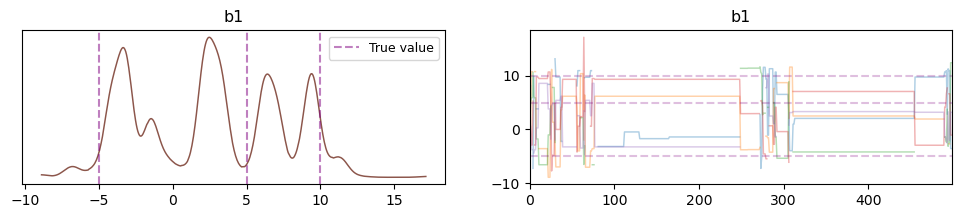

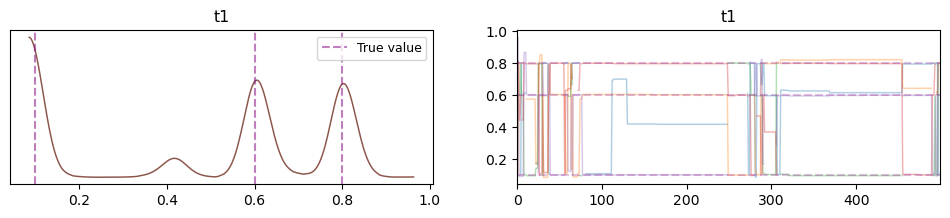

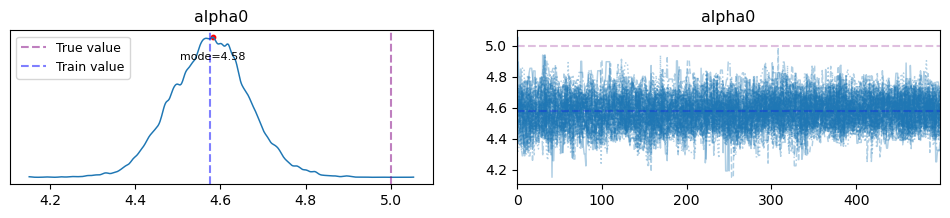

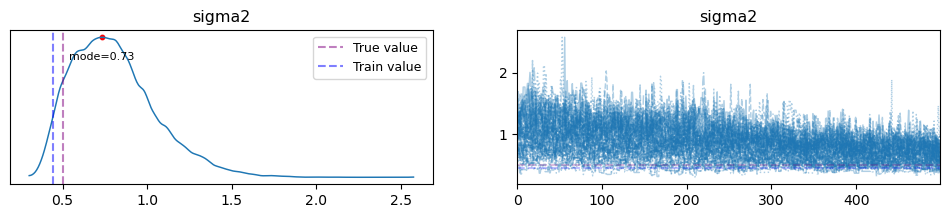

In [61]:
def plot_trace(
    chain_eryn,
    T=0,
    var_name="x",
    true_value=None,
    train_value=None,
    mode=False,
    az_kwargs={},
):
    # Get chain (nwalkers, nsamples)
    chain = np.atleast_2d(chain_eryn[:, T])
    if chain_eryn.ndim == 3:
        chain = chain.swapaxes(0, 1)  # for compatibility with arviz

    # Plot marginal posterior and trace
    ax = az.plot_trace(
        chain, combined=True, labeller=MapLabeller({"x": var_name}), **az_kwargs
    )

    # Plot reference values
    handles = []
    if true_value is not None:
        true_value = np.atleast_1d(true_value)
        for i, value in enumerate(true_value):
            h = ax[0, 0].axvline(
                x=value, color="purple", linestyle="--", alpha=0.5, label="True value"
            )
            ax[0, 1].axhline(y=value, color="purple", linestyle="--", alpha=0.25)

            if i == 0:
                handles += [h]

    if train_value is not None:
        train_value = np.atleast_1d(train_value)
        for i, value in enumerate(train_value):
            h = ax[0, 0].axvline(
                x=value, color="b", linestyle="--", alpha=0.5, label="Train value"
            )
            ax[0, 1].axhline(y=value, color="b", linestyle="--", alpha=0.25)

            if i == 0:
                handles += [h]

    if mode:
        # Compute mode
        arr, density = az.kde(chain)
        idx_mode = np.argmax(density)
        mode = arr[idx_mode]

        ax[0, 0].text(
            mode,
            ax[0, 0].get_ylim()[1] * 0.8,
            f"mode={mode:.2f}",
            horizontalalignment="center",
            fontsize=8,
        )
        ax[0, 0].scatter(mode, density[idx_mode], color="red", s=10)

    if true_value is not None or train_value is not None:
        ax[0, 0].legend(handles=handles, fontsize=9)


# Get chain from sampler
chain = ensemble.get_chain(discard=0)

components_all = chain["components"]
inds_components = ensemble.get_inds()["components"]
components = components_all[inds_components]  # same as components_all[~np.isnan]
b_all_models = components_all[..., 0, :, 0]
t_all_models = components_all[..., 0, :, 1]

common = chain["common"].squeeze()
alpha0_chain = common[..., 0]
sigma2_chain = common[..., 1]

# Plot trace
print("Posterior distribution and trace across all walkers (T=1)")
print("  * right now, we are only showing the first component")
plot_trace(
    b_all_models, 0, "b1", component_params[:, 0], az_kwargs={"chain_prop": "color"}
)
plot_trace(
    t_all_models, 0, "t1", component_params[:, 1], az_kwargs={"chain_prop": "color"}
)
plot_trace(alpha0_chain, 0, "alpha0", alpha0, Y.mean(), mode=True)
plot_trace(
    sigma2_chain,
    0,
    "sigma2",
    sigma2,
    np.var(y[idx_train] - y_noiseless[idx_train]),
    mode=True,
)

In [20]:
from sklearn.cluster import KMeans

b = components_all[..., 0]
tt = components_all[..., 1]
b_new = b.copy()
t_new = tt.copy()

km = KMeans(n_clusters=5)
new_idx = km.fit_predict(b[inds_components].reshape(-1, 1))
b_new[inds_components] = b[inds_components][new_idx]
t_new[inds_components] = tt[inds_components][new_idx]

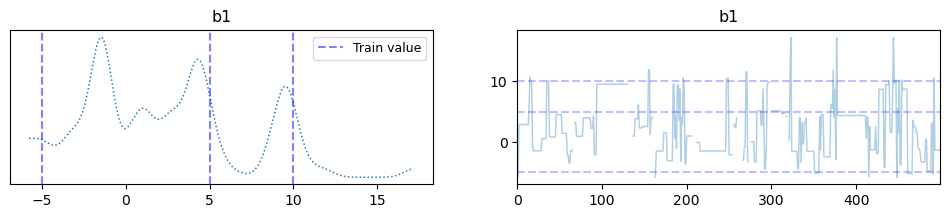

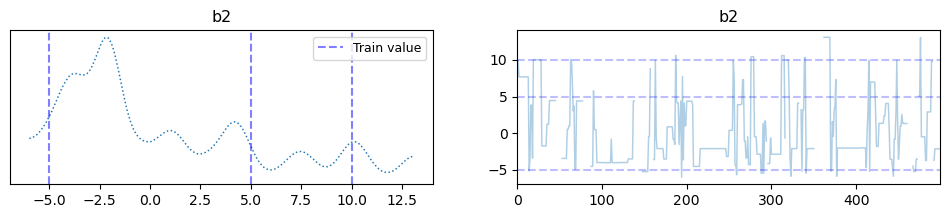

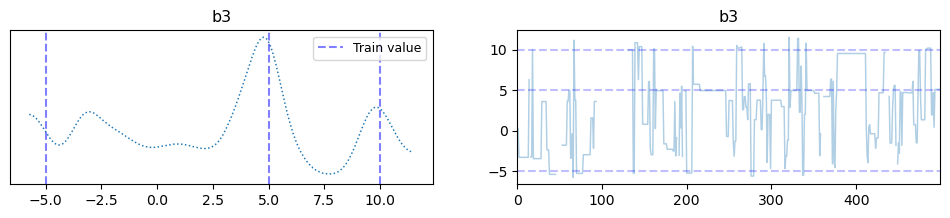

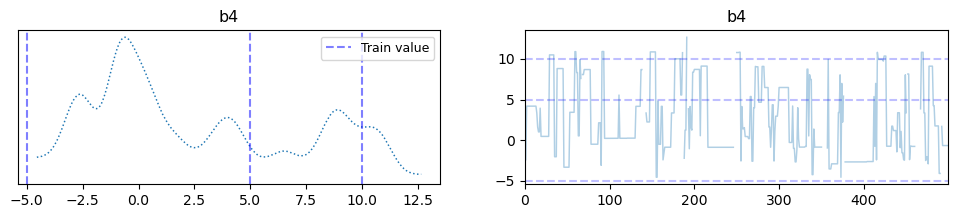

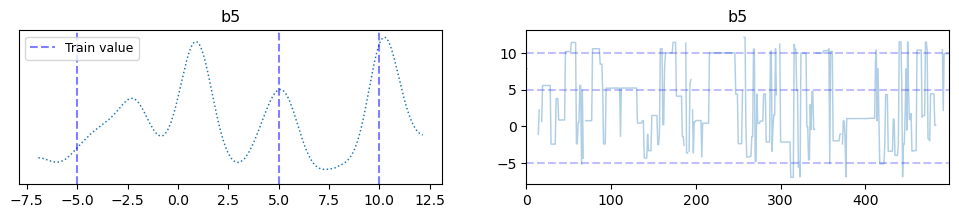

In [21]:
for i in range(5):
    plot_trace(b[:, :, 0, i], train_value=component_params[:, 0], var_name=f"b{i+1}")

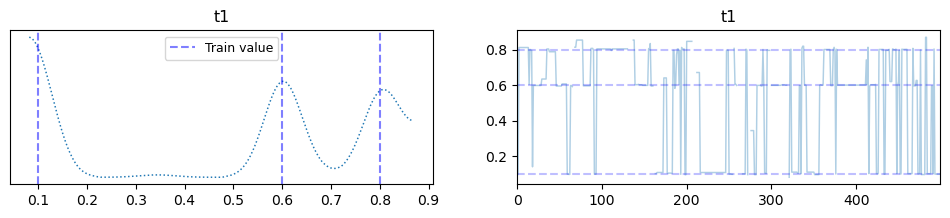

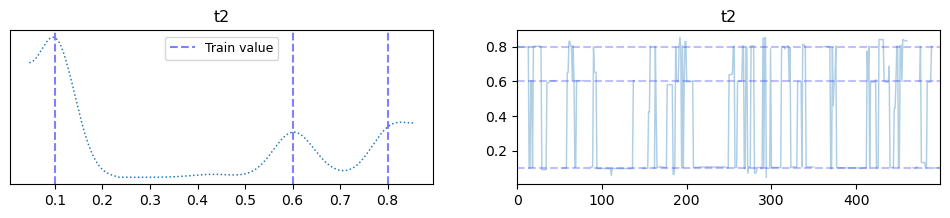

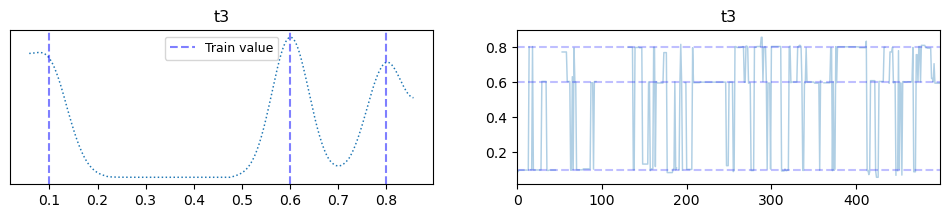

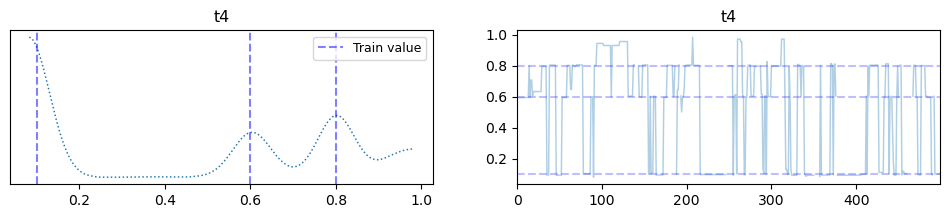

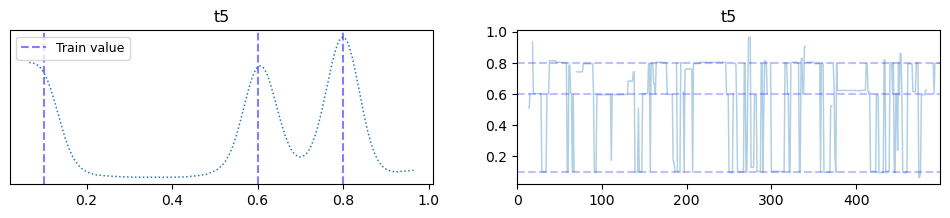

In [22]:
for i in range(5):
    plot_trace(tt[:, :, 0, i], train_value=component_params[:, 1], var_name=f"t{i+1}")

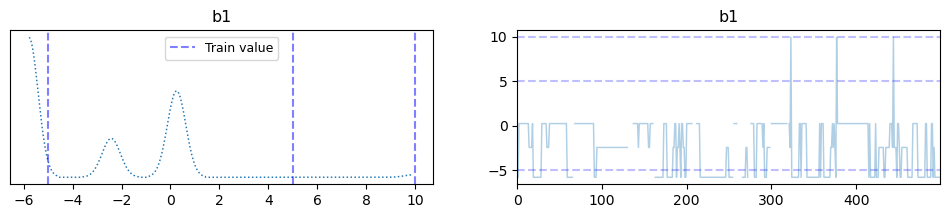

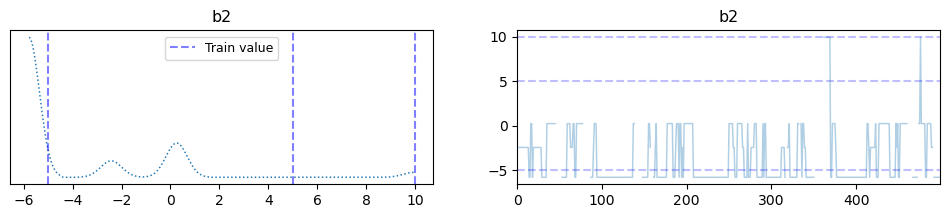

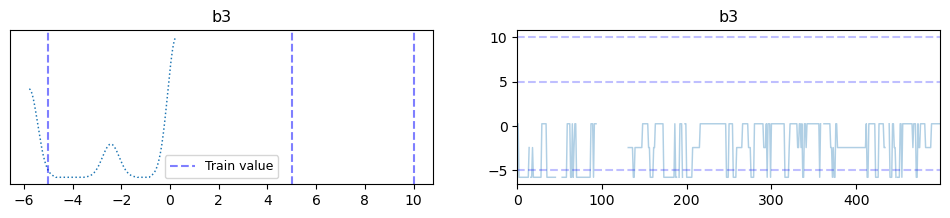

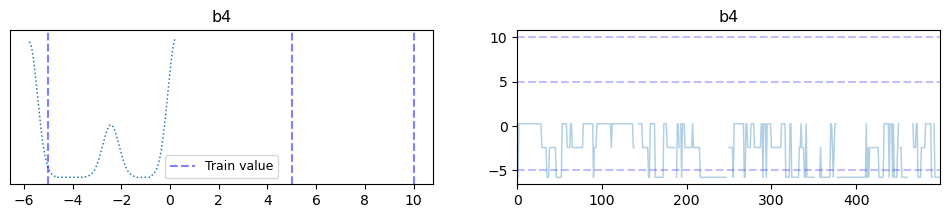

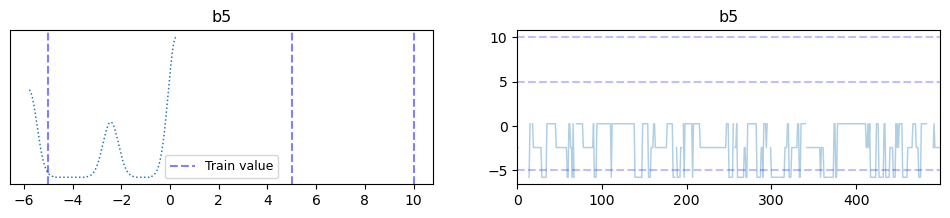

In [23]:
for i in range(5):
    plot_trace(b_new[:, :, 0, i], train_value=component_params[:, 0], var_name=f"b{i+1}")

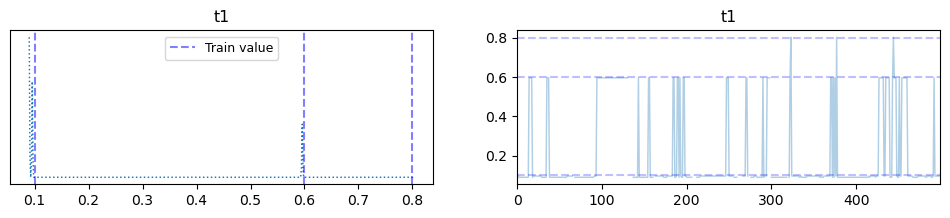

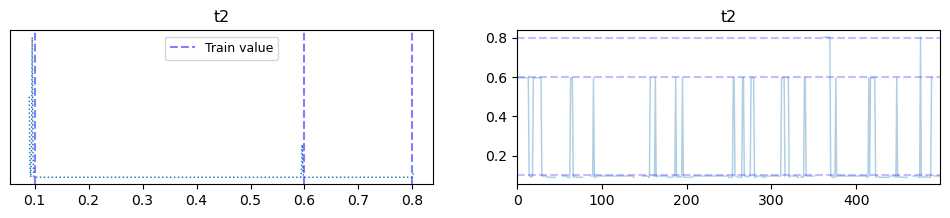

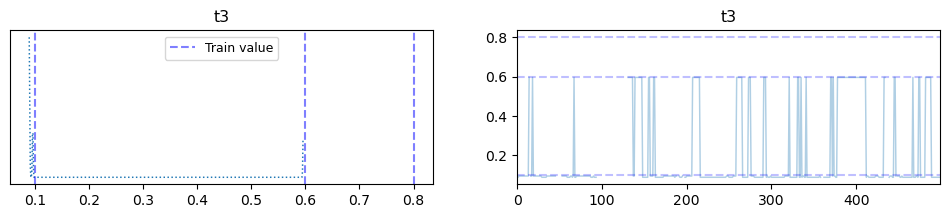

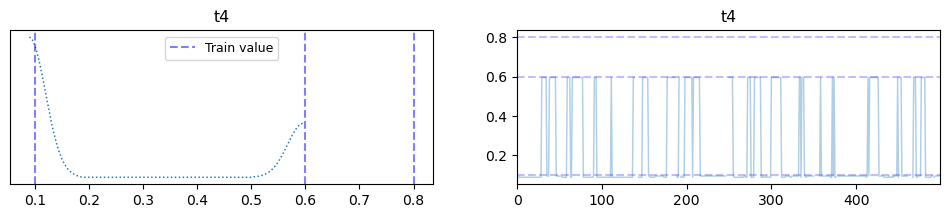

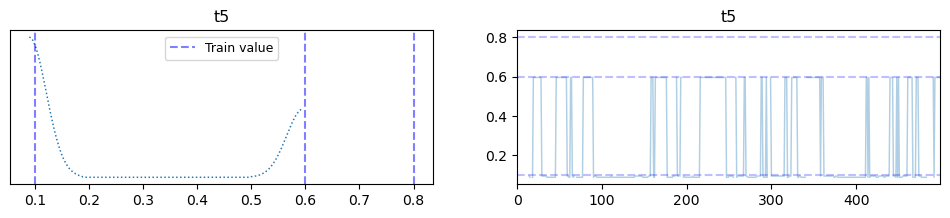

In [24]:
for i in range(5):
    plot_trace(t_new[:, :, 0, i], train_value=component_params[:, 1], var_name=f"t{i+1}")

Posterior distribution p|D of the number of components across all walkers


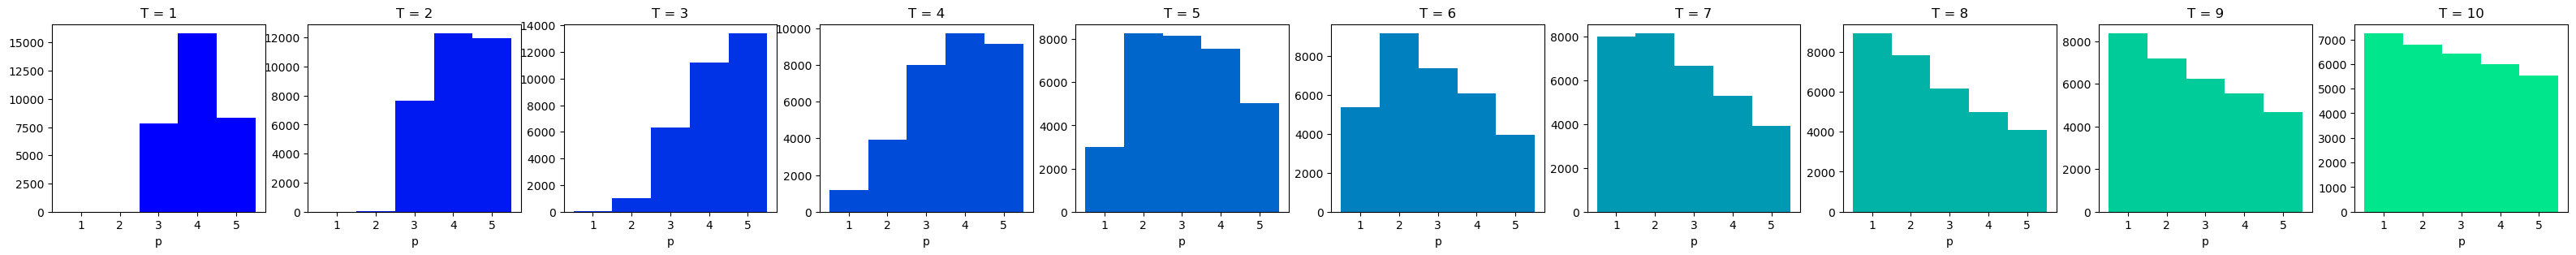

In [62]:
print("Posterior distribution p|D of the number of components across all walkers")

nleaves = ensemble.get_nleaves()["components"]
bins = np.arange(1, nleaves_max["components"] + 2) - 0.5
colors = plt.get_cmap("winter")

fig, ax = plt.subplots(1, ntemps, figsize=(4 * ntemps, 3))
for temp, ax_t in enumerate(ax):
    color = colors(temp / ntemps)
    ax_t.set_title("T = " + str(temp + 1))
    ax_t.set_xlabel("p")
    ax_t.hist(nleaves[:, temp].flatten(), bins=bins, color=color)

In [20]:
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Thu Mar 07 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

sys       : 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:43:09) [GCC 12.3.0]
numpy     : 1.23.5
arviz     : 0.17.0
matplotlib: 3.8.2

Watermark: 2.4.3

